# Coffee Bean Classification

### Imports

In [71]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Activation
from keras.optimizers import Adam
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os
from glob import glob 
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")


## Data

### Loading dataset and checking classes

In [72]:
data = pd.read_csv('data\Coffee Bean.csv')
data.head()

,class index,filepaths,labels,data set
0,0,train/Dark/dark (1).png,Dark,train
1,0,train/Dark/dark (10).png,Dark,train
2,0,train/Dark/dark (100).png,Dark,train
3,0,train/Dark/dark (101).png,Dark,train
4,0,train/Dark/dark (102).png,Dark,train


In [73]:
classes = sorted(os.listdir('data/train/'))
print(classes)

photos_per_class = [len(glob('data/train/' + name + '/*.png')) for name in classes]
photos_per_class

['Dark', 'Green', 'Light', 'Medium']


[300, 300, 300, 300]

### Loading images

In [74]:
train_data_generator = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True, 
        width_shift_range = 0.2, 
        height_shift_range = 0.2,
        shear_range = 0.2, 
        zoom_range = 0.2, 
        validation_split=0.3)

test_data_generator = ImageDataGenerator(rescale=1./255)

train_data = train_data_generator.flow_from_directory('data/train/', target_size=(224, 224), shuffle=True, 
                                                       subset='training', class_mode='categorical')
validation_data = train_data_generator.flow_from_directory('data/train/', target_size=(224, 224), shuffle=True, 
                                                       subset='validation', class_mode='categorical')
test_data = train_data_generator.flow_from_directory('data/test/', target_size=(224, 224), shuffle=True, 
                                                       class_mode='categorical')

Found 840 images belonging to 4 classes.
Found 360 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


### Images from each class in train and test set

In [75]:
def show_image(target, bean_class):
    path = target + bean_class
    image = random.sample(os.listdir(path), 1)
    img = mpimg.imread(path + '/' + image[0])
    plt.imshow(img)
    plt.title(bean_class)
    plt.axis('off')

    return img

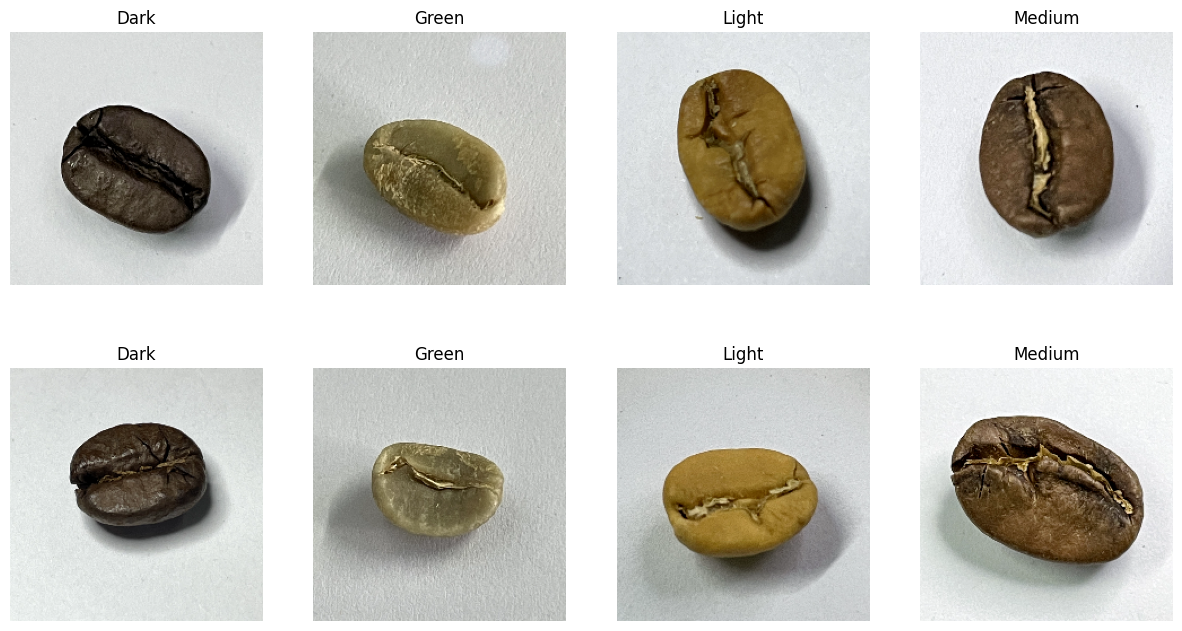

In [76]:
plt.figure(figsize = (15,8))
plt.subplot(2,4,1)
dark_bean_train = show_image('data/train/', 'Dark')
plt.subplot(2,4,2)
green_bean_train = show_image('data/train/', 'Green')
plt.subplot(2,4,3)
light_bean_train = show_image('data/train/', 'Light')
plt.subplot(2,4,4)
medium_bean_train = show_image('data/train/', 'Medium')
plt.subplot(2,4,5)
dark_bean_test = show_image('data/test/', 'Dark')
plt.subplot(2,4,6)
green_bean_test = show_image('data/test/', 'Green')
plt.subplot(2,4,7)
light_bean_test = show_image('data/test/', 'Light')
plt.subplot(2,4,8)
medium_bean_test = show_image('data/test/', 'Medium')

## Models

In [77]:
def plot_loss_curves(history):

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  #plot loss
  plt.plot(epochs, loss, label = "training_loss")
  plt.plot(epochs, val_loss, label = "val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  #plot accuracy
  plt.figure() 
  plt.plot(epochs, accuracy, label = "training_accuracy")
  plt.plot(epochs, val_accuracy, label = "val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

In [78]:
def show_results(accuracy_list: list, labels: list):
    accuracy_score = pd.DataFrame(data = accuracy_list, columns = ['Scores'])
    accuracy_score.index = labels
    accuracy_score = (accuracy_score * 100).round(4)
    plt.xticks(rotation=90)
    plt.grid(visible=None)
    plt.scatter(x=accuracy_score.index, y=accuracy_score['Scores'], c=accuracy_score['Scores'], cmap='Dark2_r')
    for i in range(len(accuracy_score['Scores'])):
        plt.annotate(str(accuracy_score['Scores'][i]), (i, accuracy_score['Scores'][i]), textcoords="offset points", xytext=(0,10))
        
accuracy_list = []
labels = []

In [79]:
model_1 = Sequential()
model_1.add(Conv2D(32, (3,3), input_shape = (224,224,3), activation="relu"))
model_1.add(MaxPooling2D(2,2))
model_1.add(Conv2D(32, (3,3), activation="relu"))
model_1.add(MaxPooling2D(2,2))
model_1.add(Conv2D(32, (3,3), activation="relu"))
model_1.add(MaxPooling2D(2,2))
model_1.add(Flatten())
model_1.add(Dense(512, activation="relu"))
model_1.add(Dropout(0.2))
model_1.add(Dense(4, activation='softmax'))

In [80]:
model_1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 54, 54, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 52, 52, 32)        9248      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 26, 26, 32)      

In [81]:
model_1.compile(loss = 'categorical_crossentropy', optimizer = 'rmsprop', metrics=['accuracy'])

In [82]:
history_1 = model_1.fit(train_data, epochs=20, steps_per_epoch=len(train_data), validation_data=validation_data, validation_steps=validation_data.samples // 32)

Epoch 1/20
27/27 [==============================] - 9s 312ms/step - loss: 2.1137 - accuracy: 0.3298 - val_loss: 1.9014 - val_accuracy: 0.2472
Epoch 2/20
27/27 [==============================] - 8s 311ms/step - loss: 1.9586 - accuracy: 0.5833 - val_loss: 0.6420 - val_accuracy: 0.7756
Epoch 3/20
27/27 [==============================] - 8s 290ms/step - loss: 0.5578 - accuracy: 0.7738 - val_loss: 1.8442 - val_accuracy: 0.5085
Epoch 4/20
27/27 [==============================] - 8s 294ms/step - loss: 0.4907 - accuracy: 0.8274 - val_loss: 0.5165 - val_accuracy: 0.7500
Epoch 5/20
27/27 [==============================] - 8s 290ms/step - loss: 0.4453 - accuracy: 0.8333 - val_loss: 0.1712 - val_accuracy: 0.9432
Epoch 6/20
27/27 [==============================] - 8s 290ms/step - loss: 0.5320 - accuracy: 0.8786 - val_loss: 0.1845 - val_accuracy: 0.9375
Epoch 7/20
27/27 [==============================] - 8s 296ms/step - loss: 0.4189 - accuracy: 0.8714 - val_loss: 0.1516 - val_accuracy: 0.9716
Epoch 

In [83]:
score_1 = model_1.evaluate(test_data)

13/13 [==============================] - 3s 205ms/step - loss: 0.4588 - accuracy: 0.8325


In [84]:
accuracy_list.append(score_1[1])
labels.append('Model 1')

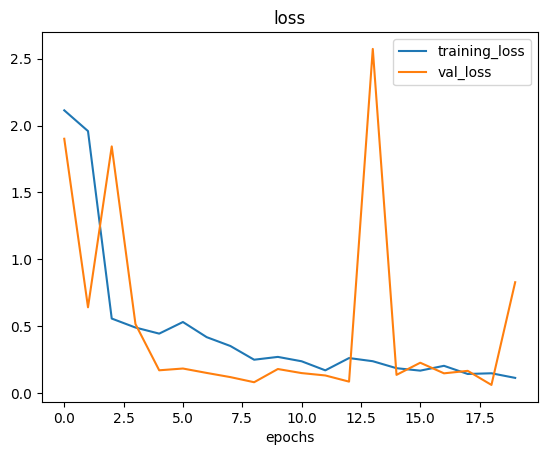

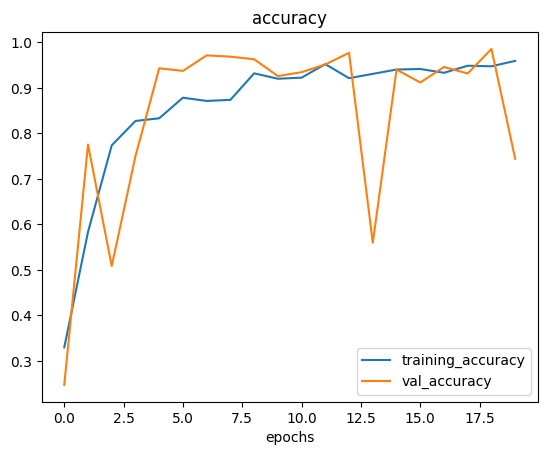

In [85]:
plot_loss_curves(history_1)

In [86]:
early_stop = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True, mode='min')
opt = Adam(lr=0.001)

In [87]:
model_1.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics=['accuracy'])

In [88]:
history_1_aes = model_1.fit(train_data, epochs=40, steps_per_epoch=len(train_data), 
                                    validation_data=validation_data, validation_steps=validation_data.samples // 32,
                                    callbacks=[early_stop],
                                    batch_size=32)

Epoch 1/40
27/27 [==============================] - 9s 315ms/step - loss: 0.1247 - accuracy: 0.9583 - val_loss: 0.0687 - val_accuracy: 0.9659
Epoch 2/40
27/27 [==============================] - 8s 297ms/step - loss: 0.0691 - accuracy: 0.9798 - val_loss: 0.0566 - val_accuracy: 0.9773
Epoch 3/40
27/27 [==============================] - 8s 293ms/step - loss: 0.0417 - accuracy: 0.9810 - val_loss: 0.1482 - val_accuracy: 0.9489
Epoch 4/40
27/27 [==============================] - 8s 295ms/step - loss: 0.0710 - accuracy: 0.9774 - val_loss: 0.1135 - val_accuracy: 0.9460
Epoch 5/40
27/27 [==============================] - 8s 292ms/step - loss: 0.0844 - accuracy: 0.9714 - val_loss: 0.0768 - val_accuracy: 0.9773
Epoch 6/40
27/27 [==============================] - 8s 303ms/step - loss: 0.0565 - accuracy: 0.9845 - val_loss: 0.0464 - val_accuracy: 0.9830
Epoch 7/40
27/27 [==============================] - 8s 295ms/step - loss: 0.0365 - accuracy: 0.9893 - val_loss: 0.0932 - val_accuracy: 0.9545
Epoch 

In [89]:
score_1_aes = model_1.evaluate(test_data)

13/13 [==============================] - 2s 187ms/step - loss: 0.0400 - accuracy: 0.9850


In [90]:
accuracy_list.append(score_1_aes[1])
labels.append('Model 1 - Adam + Early Stop')

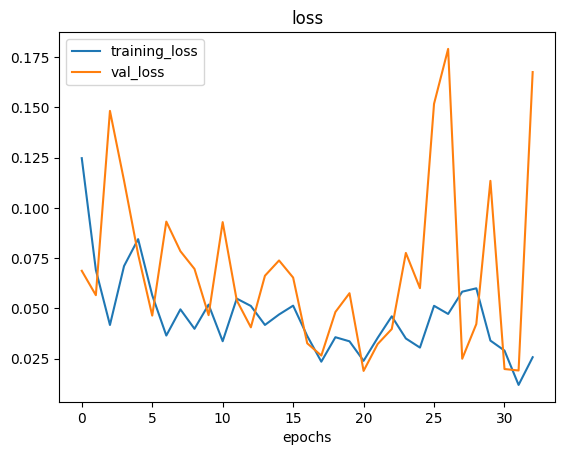

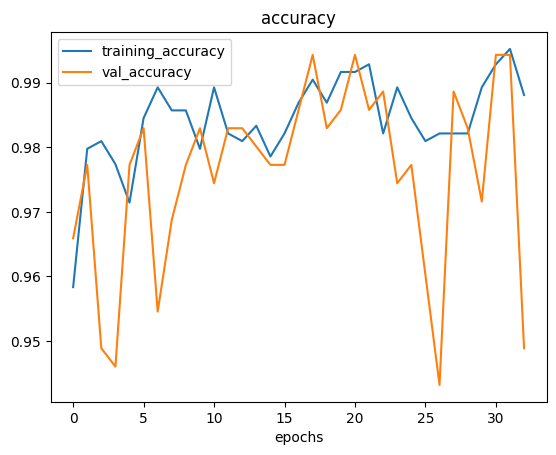

In [91]:
plot_loss_curves(history_1_aes)

In [92]:
model_2 = Sequential()
model_2.add(Conv2D(32, (3,3), input_shape = (224,224,3), activation="relu"))
model_2.add(MaxPooling2D(2,2))
model_2.add(Conv2D(32, (3,3), activation="relu"))
model_2.add(MaxPooling2D(2,2))
model_2.add(Conv2D(32, (3,3), activation="relu"))
model_2.add(MaxPooling2D(2,2))
model_2.add(Conv2D(32, (3,3), activation="relu"))
model_2.add(MaxPooling2D(2,2))
model_2.add(Flatten())
model_2.add(Dense(512, activation="relu"))
model_2.add(Dropout(0.2))
model_2.add(Dense(4, activation='softmax'))

In [93]:
model_2.compile(loss = 'categorical_crossentropy', optimizer = 'rmsprop', metrics=['accuracy'])

In [94]:
history_2 = model_2.fit(train_data, epochs=20, steps_per_epoch=len(train_data), validation_data=validation_data, validation_steps=int(0.25 * len(validation_data)))

Epoch 1/20
27/27 [==============================] - 7s 225ms/step - loss: 1.4160 - accuracy: 0.3179 - val_loss: 1.2370 - val_accuracy: 0.5000
Epoch 2/20
27/27 [==============================] - 6s 224ms/step - loss: 1.2301 - accuracy: 0.4964 - val_loss: 1.3043 - val_accuracy: 0.4792
Epoch 3/20
27/27 [==============================] - 9s 341ms/step - loss: 0.8838 - accuracy: 0.6452 - val_loss: 0.5438 - val_accuracy: 0.7812
Epoch 4/20
27/27 [==============================] - 6s 213ms/step - loss: 0.8188 - accuracy: 0.7476 - val_loss: 0.4483 - val_accuracy: 0.8750
Epoch 5/20
27/27 [==============================] - 6s 220ms/step - loss: 0.4726 - accuracy: 0.8548 - val_loss: 0.2900 - val_accuracy: 0.9688
Epoch 6/20
27/27 [==============================] - 7s 265ms/step - loss: 0.3500 - accuracy: 0.8976 - val_loss: 0.1507 - val_accuracy: 0.9583
Epoch 7/20
27/27 [==============================] - 11s 385ms/step - loss: 0.3090 - accuracy: 0.9345 - val_loss: 0.1692 - val_accuracy: 0.9375
Epoch

In [95]:
score_2 = model_2.evaluate(test_data)

13/13 [==============================] - 2s 185ms/step - loss: 0.0466 - accuracy: 0.9800


In [96]:
accuracy_list.append(score_2[1])
labels.append('Model 2')

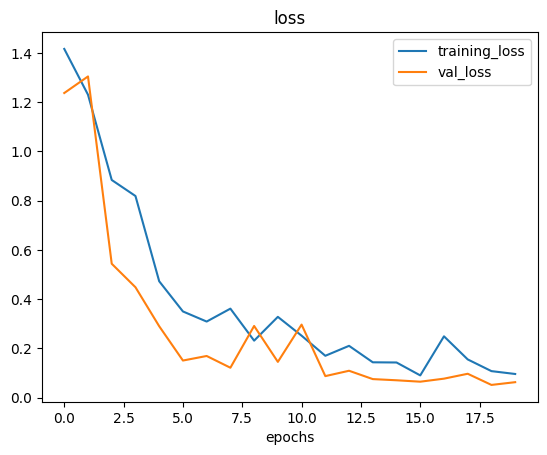

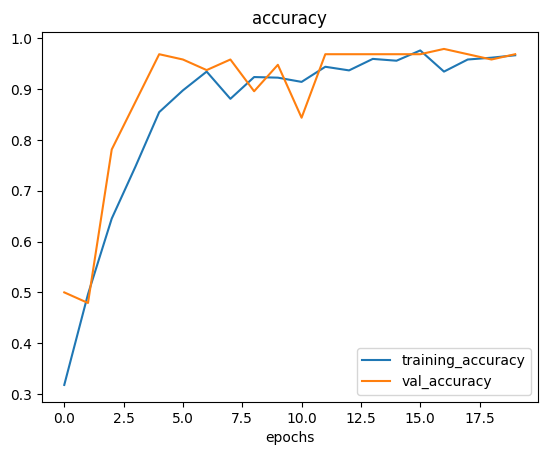

In [97]:
plot_loss_curves(history_2)

In [98]:
model_2.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics=['accuracy'])
history_2_aes = model_2.fit(train_data, epochs=50, steps_per_epoch=len(train_data), 
                                        validation_data=validation_data, validation_steps=int(0.25 * len(validation_data)),
                                        callbacks=[early_stop])

Epoch 1/50
27/27 [==============================] - 7s 229ms/step - loss: 2.2170 - accuracy: 0.5083 - val_loss: 0.7165 - val_accuracy: 0.6042
Epoch 2/50
27/27 [==============================] - 6s 219ms/step - loss: 0.4749 - accuracy: 0.8143 - val_loss: 0.2660 - val_accuracy: 0.9062
Epoch 3/50
27/27 [==============================] - 6s 220ms/step - loss: 0.2618 - accuracy: 0.9024 - val_loss: 0.1892 - val_accuracy: 0.9479
Epoch 4/50
27/27 [==============================] - 6s 216ms/step - loss: 0.1424 - accuracy: 0.9488 - val_loss: 0.1385 - val_accuracy: 0.9375
Epoch 5/50
27/27 [==============================] - 6s 219ms/step - loss: 0.1162 - accuracy: 0.9583 - val_loss: 0.0700 - val_accuracy: 0.9896
Epoch 6/50
27/27 [==============================] - 6s 217ms/step - loss: 0.0851 - accuracy: 0.9774 - val_loss: 0.1569 - val_accuracy: 0.9375
Epoch 7/50
27/27 [==============================] - 6s 217ms/step - loss: 0.0826 - accuracy: 0.9738 - val_loss: 0.1007 - val_accuracy: 0.9583
Epoch 

In [99]:
score_2_aes = model_2.evaluate(test_data)

13/13 [==============================] - 4s 341ms/step - loss: 0.0574 - accuracy: 0.9825


In [100]:
accuracy_list.append(score_2_aes[1])
labels.append('Model 2 - Adam + Early Stop')

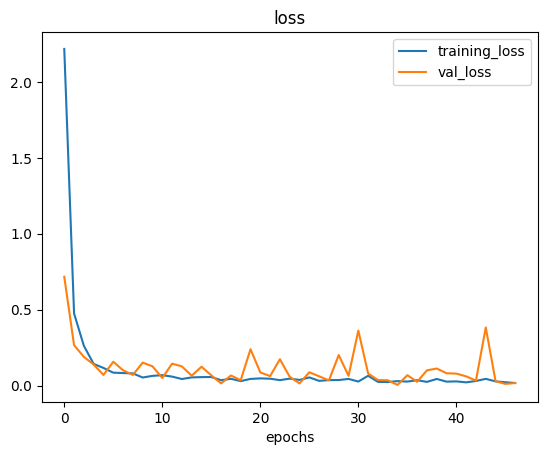

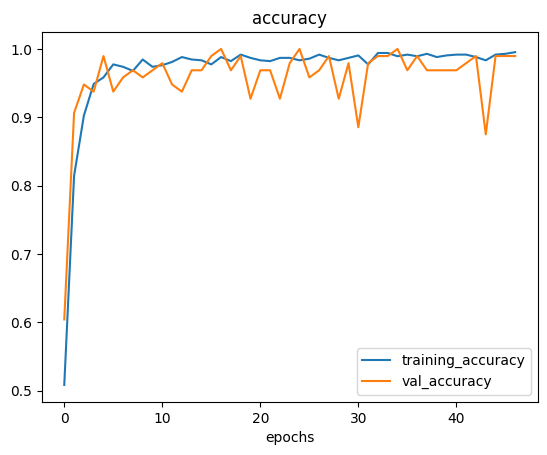

In [101]:
plot_loss_curves(history_2_aes)

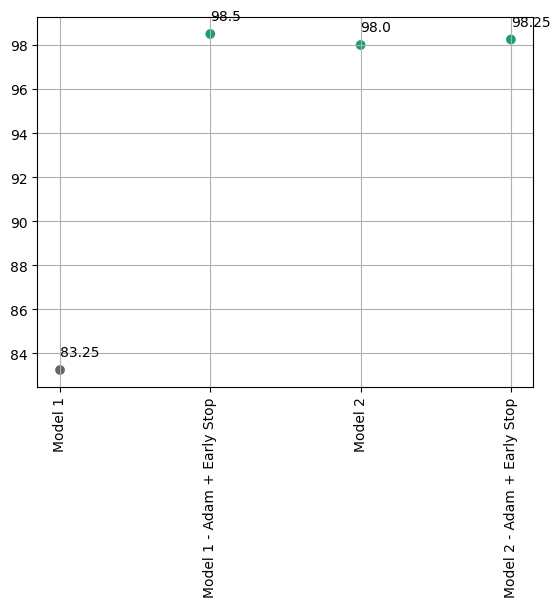

In [102]:
show_results(accuracy_list, labels)